# SandBox for MNIST Dataset

## Overview:

Due to initial hiccups with training for Chest XRay Dataset, we'll do a sanity check on the model using MNIST.
Notebook inspired by this one: https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=mMAC98JRb41t

Note that in their case they used a binary crossentropy loss as opposed to a gaussian loss.

## Data Source


### Publication

https://arxiv.org/abs/1705.02315

### URL

https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import VAE
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import cm
from warnings import warn
import os
import re
import datetime
from tqdm import tqdm
import gc
import torch.nn.functional as F

In [2]:
# run options
torch.manual_seed(42)
num_epochs = 10
batch_size = 1000
learning_rate = 1e-3
use_GPU = True
if not torch.cuda.is_available():
    warn('torch.cuda.is_available() returned False, using CPU')
else:
    print('using GPU')

device = torch.device("cuda:0" if use_GPU and torch.cuda.is_available() else "cpu")

using GPU


In [3]:
# top_dir = '/home/owhitley/projects/chest_xray_8'
top_dir = 'D:\\projects\\chest_XRay_8'
# mean and std deviation manually found on random batch of 1000 samples
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1314, 0.3090)
])
# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0.5, 0.3090)
# ])
train_dataset = MNIST(root=os.path.join(top_dir, 'data\\MNIST'), download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root=os.path.join(top_dir, 'data\\MNIST'), download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [4]:
vae_model = VAE.VariationalAutoEncoder(input_size = 28, n_conv = 2, fc0_dims = 32, latent_dims = 16, c = 4)
vae_model.to(device)

VariationalAutoEncoder(
  (encoder): Encoder(
    (conv_layers): ModuleList(
      (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (norm_layers): ModuleList()
    (fc0): Linear(in_features=392, out_features=32, bias=True)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (tconv_layers): ModuleList(
      (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ConvTranspose2d(4, 1, k

# Train Model

In [5]:
optimizer = torch.optim.Adam(params=vae_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae_model.set_train_status(True)

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        x = image_batch.to(device)

        # vae reconstruction
        recon_x, z, mu, logvar = vae_model.forward(x)
        
        # reconstruction error
        loss, _, _ = VAE.vae_loss(recon_x, x, mu, logvar)
        # print('Batch loss:{}'.format(loss.item()))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] Loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    gc.collect()

Training ...
Epoch [1 / 10] Loss: 1141105.341667
Epoch [2 / 10] Loss: 977579.832292
Epoch [3 / 10] Loss: 897272.902083
Epoch [4 / 10] Loss: 863868.407292
Epoch [5 / 10] Loss: 843205.739583
Epoch [6 / 10] Loss: 829115.521875
Epoch [7 / 10] Loss: 818891.633333
Epoch [8 / 10] Loss: 811690.955208
Epoch [9 / 10] Loss: 806128.131250
Epoch [10 / 10] Loss: 802025.240625


In [6]:
x.shape

torch.Size([1000, 1, 28, 28])

In [7]:
recon_x.shape

torch.Size([1000, 1, 28, 28])

In [8]:
vae_model.decoder

Decoder(
  (tconv_layers): ModuleList(
    (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc0): Linear(in_features=32, out_features=392, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0_bn): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

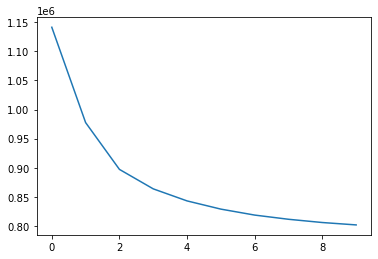

In [9]:
# training loss
plt.plot(train_loss_avg)

Original images


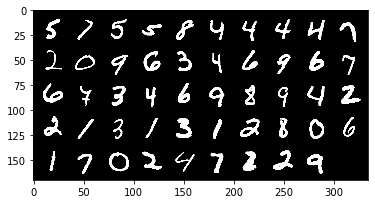

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VAE reconstruction:


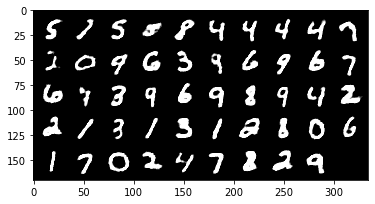

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae_model.set_train_status(False)

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = to_img(images)
        images, _, _, _ = model.forward(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).cpu().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_model)

C:\Users\newot\anaconda3\envs\pytorch38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

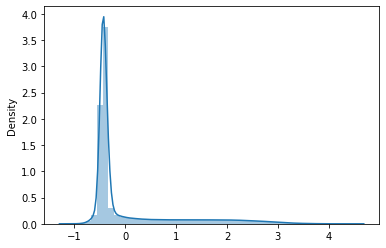

In [11]:
# check that model does not ReLU the output layer
sns.distplot(vae_model.forward(images.to(device))[0].to('cpu').detach().numpy())

C:\Users\newot\anaconda3\envs\pytorch38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

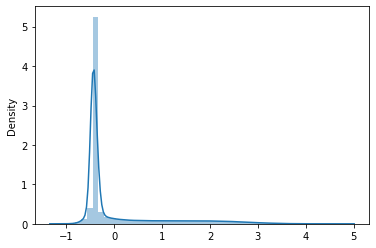

In [12]:
sns.distplot(recon_x.to('cpu').detach().numpy())

C:\Users\newot\anaconda3\envs\pytorch38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

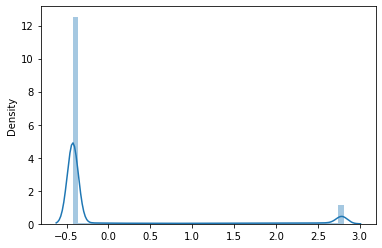

In [13]:
sns.distplot(x.to('cpu').detach().numpy())